In [129]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy
import glob
import os

In [130]:
IMAGE_SIZE=256
BATCH_SIZE=16
EPOCHS=10

In [131]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"teeth",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 256 files belonging to 2 classes.


In [132]:
class_names=dataset.class_names
class_names

['caries', 'without_caries']

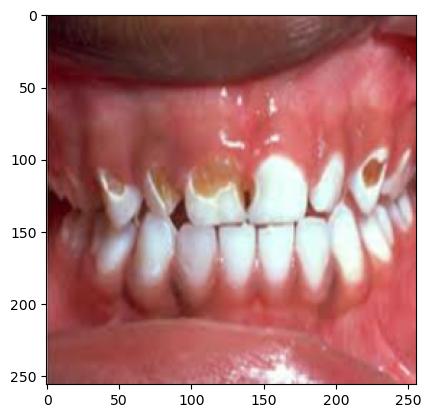

In [133]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))

In [134]:
def get_dataset_partition(ds,train_split=0.8,valid_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    ds_size=len(ds)
    train_size=int(ds_size*train_split)
    valid_size=int(ds_size*valid_split)
    train_ds=ds.take(train_size)
    valid_ds=ds.skip(train_size).take(valid_size)
    test_ds=ds.skip(train_size).skip(valid_size)
    return train_ds,valid_ds,test_ds

In [135]:
train_ds,valid_ds,test_ds=get_dataset_partition(dataset)

In [136]:
len(train_ds)

12

In [137]:
len(test_ds)

3

In [138]:
len(valid_ds)

1

In [139]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [140]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [141]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.1,width_factor=0.1)
])

In [142]:
#MODEL BUILDING
input_size=(BATCH_SIZE,(IMAGE_SIZE,IMAGE_SIZE),3)
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
     
])            

In [143]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [146]:
history=model.fit(
train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds

)

Epoch 1/10
12/12 [==============================] - 8s 532ms/step - loss: 0.4350 - accuracy: 0.9323 - val_loss: 0.3905 - val_accuracy: 0.8750
Epoch 2/10
12/12 [==============================] - 6s 507ms/step - loss: 0.3201 - accuracy: 0.9323 - val_loss: 0.3933 - val_accuracy: 0.8750
Epoch 3/10
12/12 [==============================] - 6s 503ms/step - loss: 0.2357 - accuracy: 0.9323 - val_loss: 0.2585 - val_accuracy: 0.8750
Epoch 4/10
12/12 [==============================] - 6s 503ms/step - loss: 0.1603 - accuracy: 0.9323 - val_loss: 0.1550 - val_accuracy: 0.8750
Epoch 5/10
12/12 [==============================] - 6s 504ms/step - loss: 0.1018 - accuracy: 0.9323 - val_loss: 0.1256 - val_accuracy: 0.8750
Epoch 6/10
12/12 [==============================] - 6s 507ms/step - loss: 0.0943 - accuracy: 0.9375 - val_loss: 0.1582 - val_accuracy: 0.9375
Epoch 7/10
12/12 [==============================] - 6s 503ms/step - loss: 0.0788 - accuracy: 0.9635 - val_loss: 0.1101 - val_accuracy: 0.9375
Epoch 

In [148]:
scores=model.evaluate(test_ds)

3/3 [==============================] - 0s 83ms/step - loss: 0.1134 - accuracy: 0.9792


In [149]:
history

In [150]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [151]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


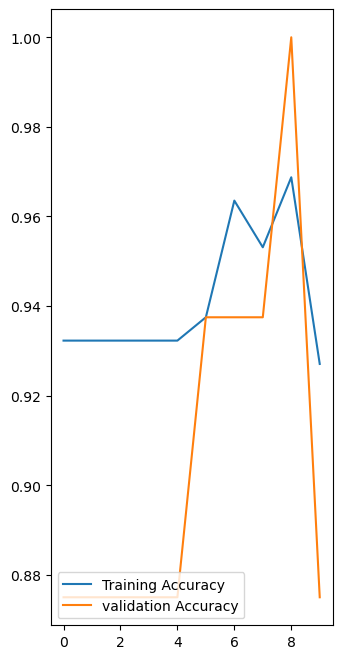

In [152]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='validation Accuracy')
plt.legend(loc='lower left')

actual label: caries
1/1 [==============================] - 0s 117ms/step
predicted label: caries


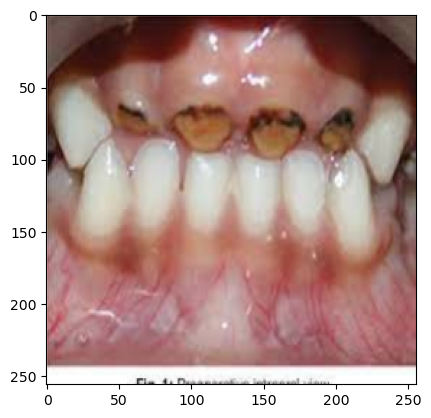

In [188]:
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    print("actual label:",class_names[label_batch[0]])
    batch_prediction=model.predict(image_batch)
    print("predicted label:",class_names[numpy.argmax(batch_prediction[0])])